<a href="https://colab.research.google.com/github/somayeh1404/cod/blob/main/CNN_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d quynhlecl/lung-cancer-x-ray


!unzip Chest X-Ray Images (lung cancer).zip

!ls

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/quynhlecl/lung-cancer-x-ray
License(s): MIT
 99% 2.27G/2.28G [00:20<00:00, 41.4MB/s]
100% 2.28G/2.28G [00:20<00:00, 118MB/s] 
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `unzip Chest X-Ray Images (lung cancer).zip'
lung-cancer-x-ray.zip  sample_data


In [2]:
!pip install torch torchvision

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [2]:
import os
import zipfile

# بررسی فایل‌های موجود
print("فایل‌های موجود در /content:")
for item in os.listdir('/content'):
    item_path = os.path.join('/content', item)
    if os.path.isfile(item_path):
        print(f"📄 {item} - حجم: {os.path.getsize(item_path) / (1024*1024):.2f} MB")
    else:
        print(f"📁 {item}")

# نام فایل زیپ
zip_file = "/content/lung-cancer-x-ray.zip"

# بررسی وجود فایل زیپ
if os.path.exists(zip_file):
    print(f"\nفایل زیپ یافت شد: {zip_file}")

    # ایجاد پوشه برای extract
    extract_path = "/content/lung_cancer_dataset"
    os.makedirs(extract_path, exist_ok=True)

    # Extract فایل زیپ
    print(f"در حال extract کردن فایل زیپ به: {extract_path}")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print("Extract کامل شد!")

    # بررسی محتوای extract شده
    print("\nمحتوای پوشه extract شده:")
    for item in os.listdir(extract_path):
        item_full_path = os.path.join(extract_path, item)
        if os.path.isdir(item_full_path):
            # شمارش تعداد فایل‌ها در پوشه
            num_files = len([f for f in os.listdir(item_full_path)
                           if os.path.isfile(os.path.join(item_full_path, f))])
            print(f"📁 {item}/ (تعداد فایل: {num_files})")

            # نمایش 5 فایل اول در هر پوشه
            files = os.listdir(item_full_path)[:5]
            for file in files:
                print(f"    📄 {file}")
            if len(os.listdir(item_full_path)) > 5:
                print(f"    ... و {len(os.listdir(item_full_path)) - 5} فایل دیگر")
        else:
            print(f"📄 {item}")

    # اگر ساختار تودرتو باشد، بررسی عمیق‌تر
    def explore_directory(path, indent=0):
        for item in os.listdir(path):
            item_path = os.path.join(path, item)
            prefix = "  " * indent

            if os.path.isdir(item_path):
                print(f"{prefix}📁 {item}/")
                # بررسی محتوای پوشه اگر خالی نباشد
                sub_items = os.listdir(item_path)
                if sub_items:
                    # فقط اولین چند آیتم را نشان بده
                    for sub_item in sub_items[:3]:
                        sub_item_path = os.path.join(item_path, sub_item)
                        if os.path.isdir(sub_item_path):
                            print(f"{prefix}  📁 {sub_item}/")
                        else:
                            print(f"{prefix}  📄 {sub_item}")
                    if len(sub_items) > 3:
                        print(f"{prefix}  ... و {len(sub_items) - 3} مورد دیگر")
            else:
                # فقط فایل‌های تصویری را نشان بده
                if item.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    print(f"{prefix}🖼️ {item}")

    print("\nبررسی عمیق‌تر ساختار دیتاست:")
    explore_directory(extract_path)

else:
    print("فایل زیپ یافت نشد!")
    print("لطفاً مطمئن شوید فایل 'lung-cancer-x-ray.zip' در /content وجود دارد")

فایل‌های موجود در /content:
📁 .config
📄 lung-cancer-x-ray.zip - حجم: 2338.24 MB
📁 sample_data

فایل زیپ یافت شد: /content/lung-cancer-x-ray.zip
در حال extract کردن فایل زیپ به: /content/lung_cancer_dataset
Extract کامل شد!

محتوای پوشه extract شده:
📁 chest_xray_lung/ (تعداد فایل: 0)
    📄 val
    📄 train
    📄 chest_xray
    📄 test

بررسی عمیق‌تر ساختار دیتاست:
📁 chest_xray_lung/
  📁 val/
  📁 train/
  📁 chest_xray/
  ... و 1 مورد دیگر


مسیر دیتاست: /content/lung_cancer_dataset
تعداد کل تصاویر یافت شده: 11712


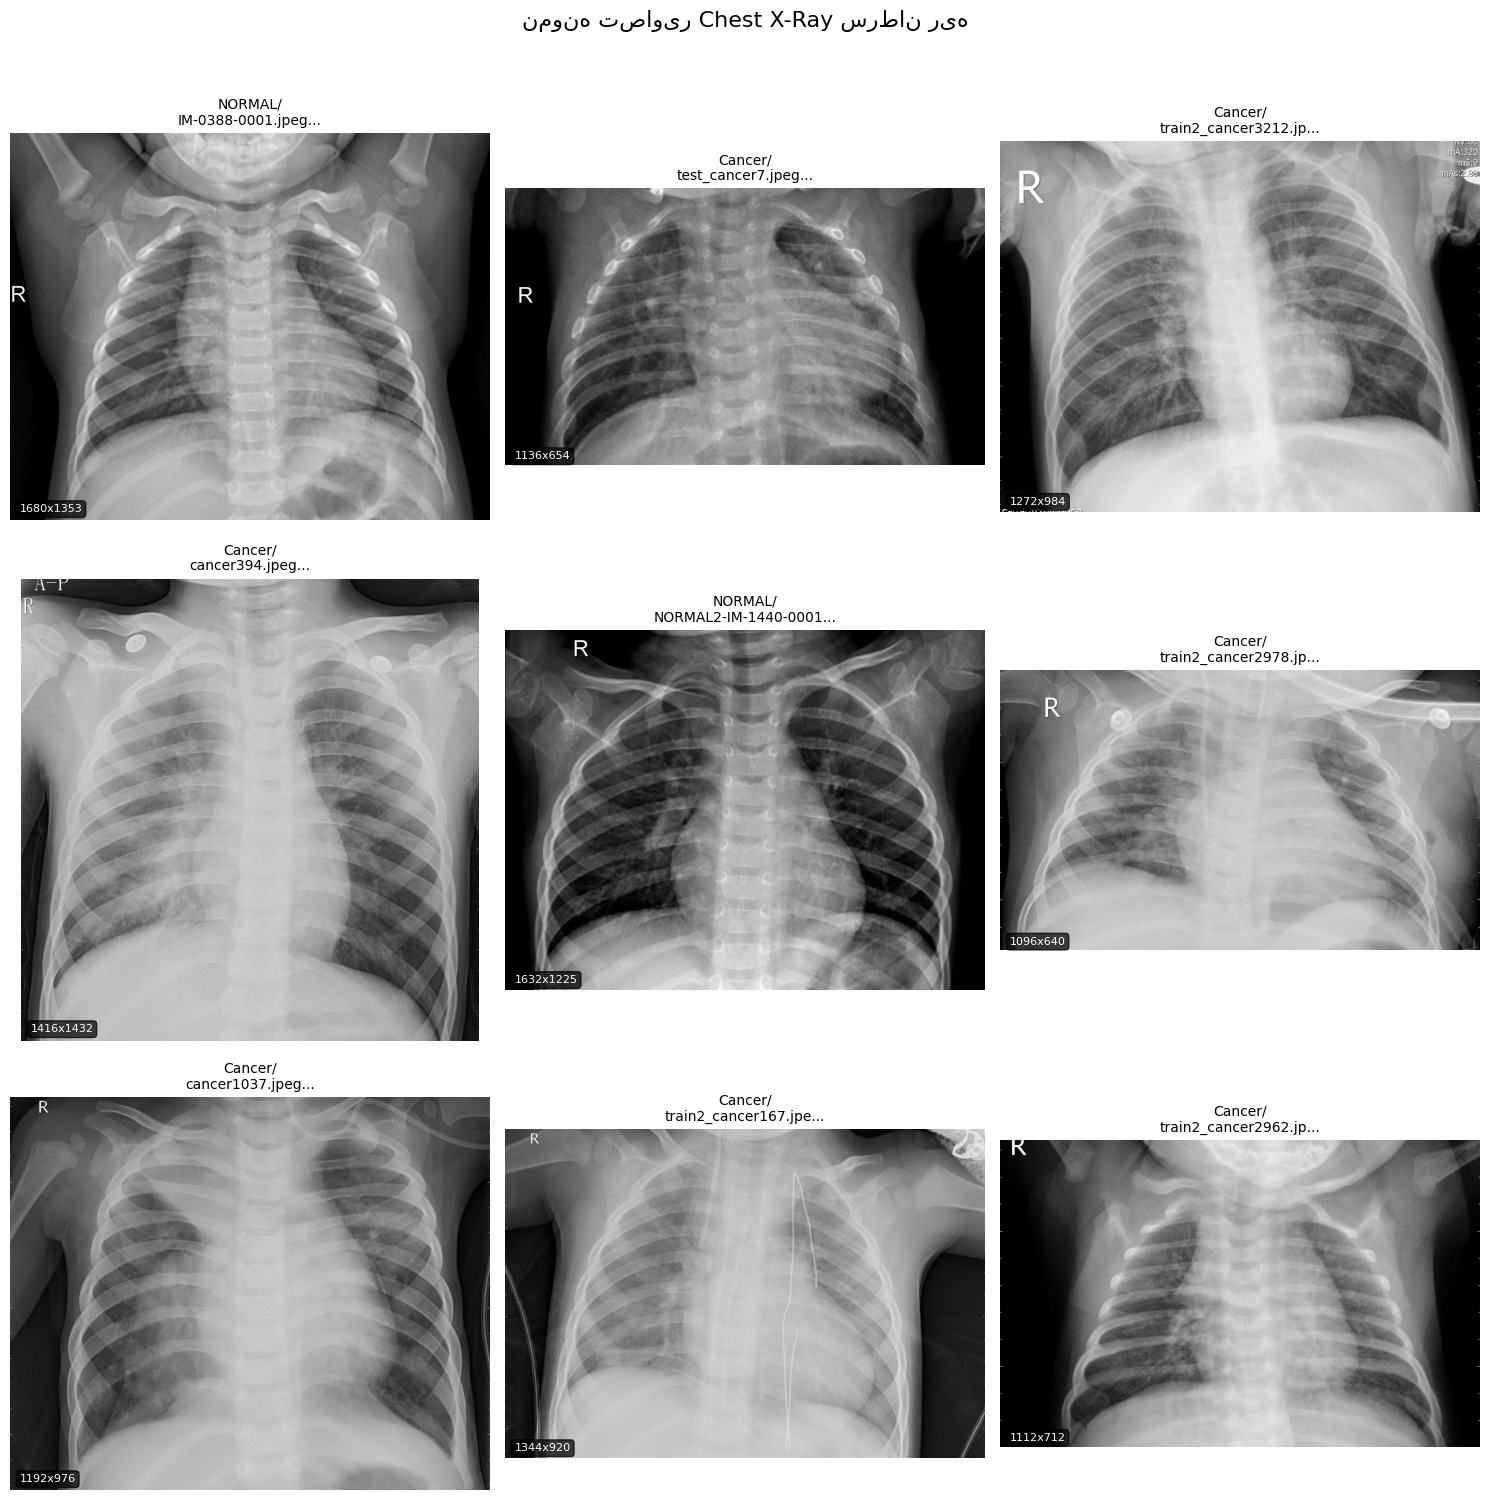


📊 اطلاعات آماری:
توزیع پسوند فایل‌ها:
  .jpeg: 100 تصویر (0.9%)

میانگین ابعاد تصاویر (بر اساس نمونه): 1252x865

📁 ساختار پوشه‌ها:
  Cancer: 8546 تصویر


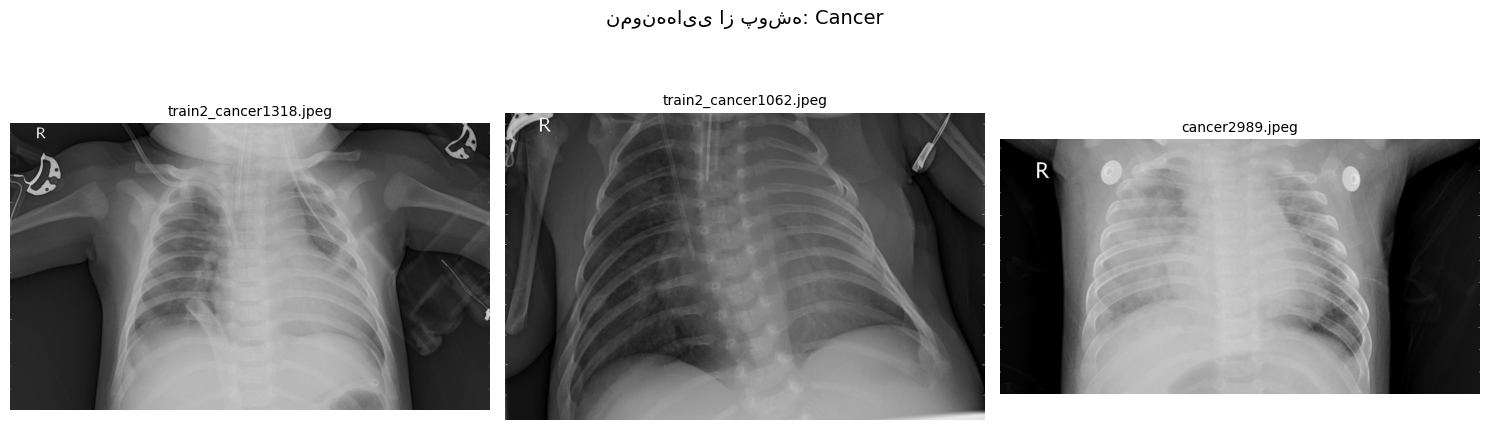

  NORMAL: 3166 تصویر


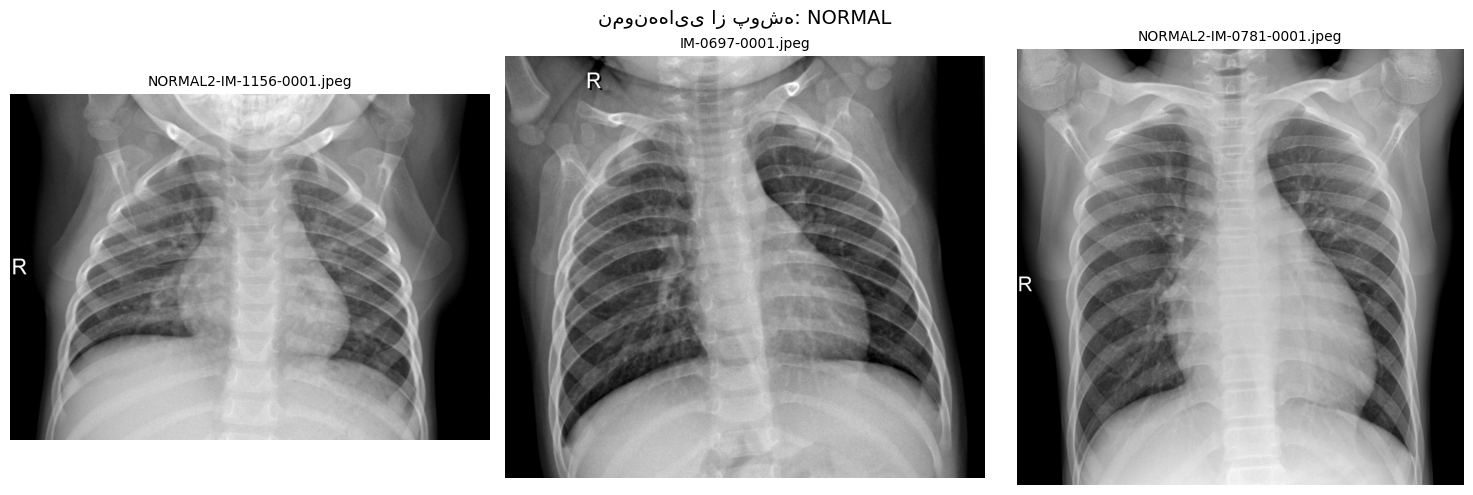

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image

# مسیر دیتاست
dataset_path = "/content/lung_cancer_dataset"

# بررسی وجود دیتاست
if not os.path.exists(dataset_path):
    print(f"پوشه دیتاست در {dataset_path} یافت نشد!")
    # ممکن است extract به مسیر دیگری انجام شده باشد
    print("جستجو برای پوشه‌های احتمالی...")
    for item in os.listdir('/content'):
        item_path = os.path.join('/content', item)
        if os.path.isdir(item_path) and item != 'sample_data' and item != '.config':
            print(f"📁 {item}")
            dataset_path = item_path
            break

print(f"مسیر دیتاست: {dataset_path}")

# تابع برای پیدا کردن همه تصاویر
def find_all_images(base_path):
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')
    images = []

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                images.append(os.path.join(root, file))

    return images

# پیدا کردن همه تصاویر
all_images = find_all_images(dataset_path)
print(f"تعداد کل تصاویر یافت شده: {len(all_images)}")

if len(all_images) > 0:
    # نمایش 9 تصویر تصادفی
    num_to_show = min(9, len(all_images))
    selected_images = random.sample(all_images, num_to_show)

    # تنظیمات نمایش
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('نمونه تصاویر Chest X-Ray سرطان ریه', fontsize=16, y=1.02)

    for idx, img_path in enumerate(selected_images):
        row = idx // 3
        col = idx % 3

        try:
            # خواندن تصویر
            img = mpimg.imread(img_path)

            # نمایش تصویر
            axes[row, col].imshow(img, cmap='gray' if len(img.shape) == 2 else None)

            # عنوان با نام فایل و پوشه والد
            parent_dir = os.path.basename(os.path.dirname(img_path))
            filename = os.path.basename(img_path)
            axes[row, col].set_title(f"{parent_dir}/\n{filename[:20]}...", fontsize=10)
            axes[row, col].axis('off')

            # نمایش ابعاد تصویر
            if hasattr(img, 'shape'):
                axes[row, col].text(0.02, 0.02, f'{img.shape[1]}x{img.shape[0]}',
                                   transform=axes[row, col].transAxes,
                                   color='white', fontsize=8,
                                   bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7))

        except Exception as e:
            print(f"خطا در خواندن {img_path}: {e}")
            axes[row, col].text(0.5, 0.5, 'خطا در بارگذاری',
                               horizontalalignment='center',
                               verticalalignment='center')
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    # نمایش اطلاعات آماری
    print("\n📊 اطلاعات آماری:")

    # گروه‌بندی بر اساس پسوند
    from collections import defaultdict
    ext_stats = defaultdict(int)
    size_stats = []

    for img_path in all_images[:100]:  # فقط 100 تصویر اول برای سرعت
        ext = os.path.splitext(img_path)[1].lower()
        ext_stats[ext] += 1

        try:
            with Image.open(img_path) as img:
                size_stats.append(img.size)
        except:
            pass

    print("توزیع پسوند فایل‌ها:")
    for ext, count in sorted(ext_stats.items()):
        percentage = (count / len(all_images)) * 100
        print(f"  {ext}: {count} تصویر ({percentage:.1f}%)")

    if size_stats:
        avg_width = sum(w for w, h in size_stats) / len(size_stats)
        avg_height = sum(h for w, h in size_stats) / len(size_stats)
        print(f"\nمیانگین ابعاد تصاویر (بر اساس نمونه): {avg_width:.0f}x{avg_height:.0f}")

    # بررسی ساختار پوشه‌ها
    print("\n📁 ساختار پوشه‌ها:")
    folder_images = defaultdict(list)

    for img_path in all_images:
        folder = os.path.basename(os.path.dirname(img_path))
        folder_images[folder].append(img_path)

    for folder, images in sorted(folder_images.items()):
        print(f"  {folder}: {len(images)} تصویر")

        # نمایش 3 نمونه از هر پوشه اگر پوشه‌های مختلف وجود دارد
        if len(folder_images) > 1 and len(images) > 0:
            sample_images = random.sample(images, min(3, len(images)))

            fig, axes = plt.subplots(1, min(3, len(images)), figsize=(15, 5))
            if min(3, len(images)) == 1:
                axes = [axes]

            fig.suptitle(f'نمونه‌هایی از پوشه: {folder}', fontsize=14)

            for idx, img_path in enumerate(sample_images):
                try:
                    img = mpimg.imread(img_path)
                    axes[idx].imshow(img, cmap='gray' if len(img.shape) == 2 else None)
                    axes[idx].set_title(os.path.basename(img_path), fontsize=10)
                    axes[idx].axis('off')
                except:
                    axes[idx].text(0.5, 0.5, 'خطا', ha='center', va='center')
                    axes[idx].axis('off')

            plt.tight_layout()
            plt.show()

else:
    print("هیچ تصویری یافت نشد!")
    print("\nبررسی محتوای دیتاست:")

    def print_tree(path, indent=0, max_depth=3):
        if indent > max_depth * 2:
            return

        for item in os.listdir(path):
            item_path = os.path.join(path, item)
            prefix = "│   " * (indent // 2) + ("├── " if indent % 2 == 0 else "└── ")

            if os.path.isdir(item_path):
                print(f"{prefix}📁 {item}/")
                if indent < max_depth * 2:
                    print_tree(item_path, indent + 2, max_depth)
            else:
                print(f"{prefix}📄 {item}")

    print_tree(dataset_path)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import zipfile


BATCH_SIZE = 32
DROPOUT = 0.5
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
IMG_SIZE = 224
PATIENCE = 5


train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def setup_dataset():
    base_path = '/content/lung-cancer-x-ray'
    zip_path = '/content/lung-cancer-x-ray.zip'

    if not os.path.exists(base_path):
        print("Downloading dataset...")
        os.makedirs('/content', exist_ok=True)

        # دانلود از کگل
        os.system('kaggle datasets download -d quynhlecl/lung-cancer-x-ray -p /content/')

        # اکسترکت کردن فایل
        if os.path.exists(zip_path):
            print("Extracting dataset...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('/content/')

            # بررسی ساختار پوشه‌ها
            extracted_paths = [
                '/content/lung-cancer-x-ray',
                '/content/Lung Cancer X-ray',
                '/content/dataset'
            ]

            for path in extracted_paths:
                if os.path.exists(path):
                    print(f"Found dataset at: {path}")
                    # اگر ساختار پوشه متفاوت است، آن را به ساختار مورد نظر تغییر می‌دهیم
                    if 'Lung Cancer X-ray' in path:
                        os.rename(path, base_path)
                    return base_path

            # اگر هیچکدام از مسیرهای فوق پیدا نشد، محتوای دایرکتوری را بررسی می‌کنیم
            print("Checking content directory structure...")
            for item in os.listdir('/content'):
                item_path = os.path.join('/content', item)
                if os.path.isdir(item_path) and ('lung' in item.lower() or 'cancer' in item.lower()):
                    print(f"Found potential dataset directory: {item_path}")
                    os.rename(item_path, base_path)
                    return base_path
        else:
            raise FileNotFoundError("Dataset zip file not found after download attempt")

    return base_path

try:
    base_path = setup_dataset()
    train_path = os.path.join(base_path, 'train')
    test_path = os.path.join(base_path, 'test')

    # بررسی وجود پوشه‌های train و test
    if not os.path.exists(train_path):
        print(f"Train path not found: {train_path}")
        print("Available directories in base path:")
        for item in os.listdir(base_path):
            print(f"  - {item}")

        # اگر ساختار متفاوت است، سعی می‌کنیم پوشه‌های مناسب را پیدا کنیم
        for item in os.listdir(base_path):
            item_path = os.path.join(base_path, item)
            if os.path.isdir(item_path):
                subitems = os.listdir(item_path)
                if 'train' in subitems or 'test' in subitems:
                    print(f"Found structured dataset in: {item_path}")
                    train_path = os.path.join(item_path, 'train')
                    test_path = os.path.join(item_path, 'test')
                    break
                elif any('train' in subitem.lower() for subitem in subitems):
                    # پیدا کردن پوشه‌های train و test
                    for subitem in subitems:
                        subitem_path = os.path.join(item_path, subitem)
                        if 'train' in subitem.lower() and os.path.isdir(subitem_path):
                            train_path = subitem_path
                        elif 'test' in subitem.lower() and os.path.isdir(subitem_path):
                            test_path = subitem_path

    print(f"Final train path: {train_path}")
    print(f"Final test path: {test_path}")

    # بارگذاری دیتاست
    train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
    test_dataset = datasets.ImageFolder(root=test_path, transform=val_transform)

    print(f"Train classes: {train_dataset.classes}")
    print(f"Test classes: {test_dataset.classes}")
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

except Exception as e:
    print(f"Error setting up dataset: {e}")
    print("Trying alternative dataset structure...")

    # روش جایگزین: بررسی تمام پوشه‌های ممکن
    possible_paths = [
        '/content/lung-cancer-x-ray',
        '/content/Lung Cancer X-ray',
        '/content/dataset',
        '/content'
    ]

    for path in possible_paths:
        if os.path.exists(path):
            print(f"Checking {path}...")
            for root, dirs, files in os.walk(path):
                for dir_name in dirs:
                    if 'train' in dir_name.lower():
                        train_path = os.path.join(root, dir_name)
                        print(f"Found train directory: {train_path}")
                    if 'test' in dir_name.lower():
                        test_path = os.path.join(root, dir_name)
                        print(f"Found test directory: {test_path}")

    if 'train_path' in locals() and 'test_path' in locals():
        train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
        test_dataset = datasets.ImageFolder(root=test_path, transform=val_transform)
    else:
        raise FileNotFoundError("Could not find train and test directories in any expected location")


# ادامه کد قبلی...
targets = np.array([label for _, label in train_dataset])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)


class_counts = np.bincount(targets[train_idx])
class_weights = 1. / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float32)


train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(DROPOUT),
    nn.Linear(num_ftrs, 2)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)


best_val_accuracy = 0
no_improve = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total


    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    scheduler.step(val_acc)

    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}:')
    print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%')


    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f'\nEarly stopping at epoch {epoch+1}')
            break


model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_labels = []
all_preds = []
test_correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_acc = 100 * test_correct / len(test_dataset)
print(f'\nTest Accuracy: {test_acc:.2f}%')
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

print('\nConfusion Matrix:')
print(confusion_matrix(all_labels, all_preds))

Extracting dataset...
Checking content directory structure...
Found potential dataset directory: /content/chest_xray_lung
Final train path: /content/lung-cancer-x-ray/train
Final test path: /content/lung-cancer-x-ray/test
Train classes: ['Cancer', 'NORMAL']
Test classes: ['Cancer', 'NORMAL']
Train dataset size: 5216
Test dataset size: 624


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]



Epoch 1/10:
Train Loss: 0.1803 | Acc: 93.17%
Val Loss: 0.2507 | Acc: 92.24%

Epoch 2/10:
Train Loss: 0.1230 | Acc: 95.78%
Val Loss: 0.1612 | Acc: 96.17%

Epoch 3/10:
Train Loss: 0.1062 | Acc: 96.09%
Val Loss: 0.0595 | Acc: 97.61%

Epoch 4/10:
Train Loss: 0.0949 | Acc: 96.38%
Val Loss: 0.0633 | Acc: 97.61%

Epoch 5/10:
Train Loss: 0.0891 | Acc: 96.62%
Val Loss: 0.0752 | Acc: 96.46%

Epoch 6/10:
Train Loss: 0.0912 | Acc: 96.50%
Val Loss: 0.1552 | Acc: 93.30%

Epoch 7/10:
Train Loss: 0.0800 | Acc: 96.88%
Val Loss: 0.0520 | Acc: 97.80%

Epoch 8/10:
Train Loss: 0.0497 | Acc: 98.08%
Val Loss: 0.0388 | Acc: 98.08%

Epoch 9/10:
Train Loss: 0.0422 | Acc: 98.54%
Val Loss: 0.0432 | Acc: 98.37%

Epoch 10/10:
Train Loss: 0.0521 | Acc: 98.08%
Val Loss: 0.0476 | Acc: 98.37%

Test Accuracy: 87.02%

Classification Report:
              precision    recall  f1-score   support

      Cancer       0.83      0.99      0.91       390
      NORMAL       0.98      0.67      0.79       234

    accuracy      